# Using `DCM-PROGRESS`
This tutorial will give an overview of the functionality of the `DCM-PROGRESS` api. For the paper describing the model derivation, please click ['here'](www.google).

In [1]:
# importing the relevant packages
import pandas as pd 
import matplotlib.pyplot as plt
from dcm_progress.example_data import examples
from dcm_progress import predict
from dcm_progress.predict import bar, plot_reference

## loading and exploring the example data
We will load data from 4 hypothetical DCM patients.

In [2]:
data = examples.get_data('example_dataset')
print(data)

            NYHA  height  heart-rate  sbp  r_axis  tapse
patient id                                              
0              1     165          60   80     -20     10
1              3     170          85  110      10     12
2              1     182          90   70      -5     25
3              4     161          78   90      40     16


## Apply DCM-PROGRESS to the dataset

In [3]:
# explain how the columns should be mapped
fit = predict.Calculate(nyha='NYHA', height='height', heartrate='heart-rate', sbp='sbp', raxis='r_axis', tapse='tapse', 
                        data=data,
                       )
# calculate the risk 
fit.calculate_risk()
# explore fit object
fit.derived_data

NYHA class    Height    R-axis  Heart rate       SBP     TAPSE  intercept  \
0    0.470411  0.030522 -0.031146   -0.055187  0.689200  0.356856  -2.378597   
1    1.411232  0.016164  0.000575    0.019040  0.177602  0.275142  -2.378597   
2    0.470411 -0.018295 -0.015285    0.033885  0.859733 -0.256005  -2.378597   
3    1.881642  0.042008  0.032295   -0.001743  0.518667  0.111712  -2.378597   

   cor-intercept  cor-slope  risk (calibrated)  
0       2.571771   2.603559           0.545339  
1       2.571771   2.603559           0.790025  
2       2.571771   2.603559           0.304985  
3       2.571771   2.603559           0.957224

### Calculating the uncalibrated risk
During derviation of the DCM-PROGRESS model the predicted risks were recalibrated using the training model (default output), to obtain the crude (uncalibrated) risks set `corrected=False`. 

In [4]:
fit.calculate_risk(corrected=False)
fit.derived_data

NYHA class    Height    R-axis  Heart rate       SBP     TAPSE  intercept  \
0    0.470411  0.030522 -0.031146   -0.055187  0.689200  0.356856  -2.378597   
1    1.411232  0.016164  0.000575    0.019040  0.177602  0.275142  -2.378597   
2    0.470411 -0.018295 -0.015285    0.033885  0.859733 -0.256005  -2.378597   
3    1.881642  0.042008  0.032295   -0.001743  0.518667  0.111712  -2.378597   

   cor-intercept  cor-slope  risk (crude)  
0       2.571771   2.603559      0.285378  
1       2.571771   2.603559      0.382525  
2       2.571771   2.603559      0.213467  
3       2.571771   2.603559      0.551315

## Calculate the DCM-PROGRESS score using floats and integers
The DCM-PROGRESS score can also be calculate for a single individual by simply supplying integer/float values instead of string and leaving the `data` parameter empty. 


In [5]:

fit = predict.Calculate(nyha=1, height=182, heartrate=90, sbp=70, raxis=-5, tapse=25, 
                       )
res = fit.calculate_risk()
res.derived_data

NYHA class    Height    R-axis  Heart rate       SBP     TAPSE  intercept  \
0    0.470411 -0.018295 -0.015285    0.033885  0.859733 -0.256005  -2.378597   

   cor-intercept  cor-slope  risk (calibrated)  
0       2.571771   2.603559           0.304985

## Illustrating risk
The package contains two plotting functions which might be used to inform patient and/or medical professionals. 

* A bar chart function useful to visualize the patient characteristics (loosely referred to here as `risk factor`) to contributions to the risk of end-stage HF. Note that the risk factor contributions of course do not necessarily inform interventional target. For example a large contribution of SBP to the risk does not necessarily imply that interventions acting through or targeting SBP will prevent end-stage HF. Fundementally `DCM-PROGRESS` is a prediction model, not a causal model.  
* A histogram function to visualize an individual's predicted risk relative to simulated risk distrubtion prportion to the external validation data.

### Bar chart

In [6]:
RF = 'Risk factor'
PER = 'Percentage'
# reformat the data
data = pd.DataFrame(res.relative_risk_absolute.iloc[:,0:6].copy().T)
data[RF] = data.index
data.columns = [PER, RF]
print(data)

            Percentage Risk factor
NYHA class    0.284474  NYHA class
Height        0.011063      Height
Heart rate    0.020492  Heart rate
SBP           0.519911         SBP
R-axis        0.009244      R-axis
TAPSE         0.154815       TAPSE


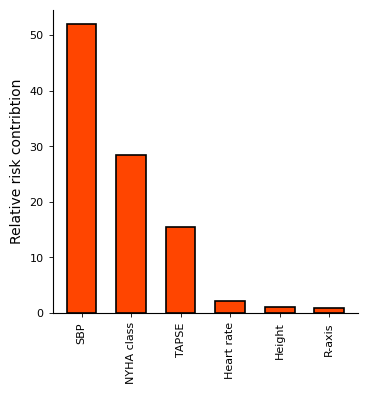

In [7]:
# plotting the contribution of each risk factor has to the predicted risk
TICKS_WD = 0.6
CMTOINCH = 1/2.54
fig,  ax = plt.subplots(figsize=(10 * CMTOINCH, 10 *CMTOINCH))
# bar plot
_ = bar(data, label=RF, column=PER, colours='orangered',wd=0.6, ax=ax, transparancy=1.0,
   linewidth=1.2, percentage=True, ascend=False)
# labels and ticks
ax.tick_params(axis="x", labelsize=8.0, length=3, width=TICKS_WD, rotation=90)
ax.tick_params(axis="y", labelsize=8.0, length=3, width=TICKS_WD, rotation=0)

### Comparison against reference data

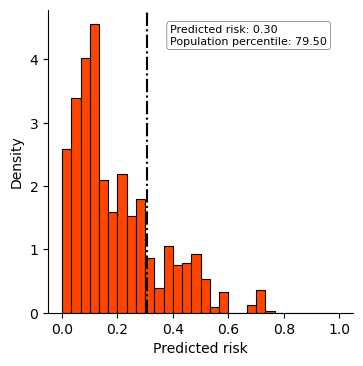

In [8]:
fig,  ax = plt.subplots(figsize=(10 * CMTOINCH, 10 *CMTOINCH))
# histogram
ax = plot_reference(float(res.derived_data['risk (calibrated)']), ax=ax, colour='orangered',
              annot_loc=(0.40, 0.95), vlw=1.5, vcolour='black', vline='-.',
              )

# Please consult the documentation

In [9]:
# please see the help function for more information 
help(predict)

Help on module dcm_progress.predict in dcm_progress:

NAME
    dcm_progress.predict

DESCRIPTION
    This module will implement the DCM-PROGRESS model, predicting 5-years risk of
    end-stage heart failure in patient with dilated cardiomyopathy.
    
    Additionally, there is some code to calculate the patient characteristic
    driving the predicted risk. Please `note` that irrespective of the contribution
    to the predicted 5-years risk, the relative contribution of a characteristic
    says little about the causal consequence of an intervention. In other words
    this is a risk prediction module, not a causal model. Likely, in many cases
    simply following guideline recommended treatment intensification is the better
    strategy, rather than targeting a specific characteristic say heart rate.
    
    Notes
    -----
    Please read, and where relevant, cite the original publication:
    `Here <ADD URL>`_.

CLASSES
    builtins.Exception(builtins.BaseException)
        Input